# Batch Effect Correction

In [1]:
import os
import sys
import glob
import time
import math
import datetime
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import mindspore as ms
import mindspore.numpy as mnp
import mindspore.scipy as msc
import mindspore.dataset as ds
from tqdm import tqdm,trange
from functools import partial
from mindspore import nn,ops
from scipy.sparse import csr_matrix as csm
from mindspore.ops import operations as P
from mindspore.amp import FixedLossScaleManager,all_finite,DynamicLossScaleManager
from mindspore.train import Model, CheckpointConfig, ModelCheckpoint, LossMonitor
from mindspore.context import ParallelMode
from mindspore.communication import init, get_rank, get_group_size
from mindspore.parallel._utils import _get_parallel_mode
from mindspore.common.initializer import initializer, XavierNormal

[ERROR] ME(1426944:139664040773440,MainProcess):2024-12-16-22:38:45.742.587 [mindspore/run_check/_check_version.py:230] Cuda ['10.1', '11.1', '11.6'] version(libcudart*.so need by mindspore-gpu) is not found. Please confirm that the path of cuda is set to the env LD_LIBRARY_PATH, or check whether the CUDA version in wheel package and the CUDA runtime in current device matches. Please refer to the installation guidelines: https://www.mindspore.cn/install
[ERROR] ME(1426944:139664040773440,MainProcess):2024-12-16-22:38:45.803.141 [mindspore/run_check/_check_version.py:230] Cuda ['10.1', '11.1', '11.6'] version(libcudnn*.so need by mindspore-gpu) is not found. Please confirm that the path of cuda is set to the env LD_LIBRARY_PATH, or check whether the CUDA version in wheel package and the CUDA runtime in current device matches. Please refer to the installation guidelines: https://www.mindspore.cn/install
[WARNING] ME(1426944:139664040773440,MainProcess):2024-12-16-22:38:45.806.186 [mindsp

In [2]:
sys.path.append('../..')

In [3]:
from config import Config
from finetune_intergration_model import *
from utils import Wrapper
from metrics import eval_batch
from utils import eval_scib_metrics
from model import *

In [4]:
# read data
def read_h5ad(path, test_rate=0.1):
    '''
    load dataset and split train and valid
    '''
    # read anndata
    suffix=path.split('.')[-1]
    if suffix=='h5ad':
        adata=sc.read_h5ad(path)
    else:
        adata=sc.read_10x_h5(path)
    print('origin shape:',adata.shape,len(adata.obs['cell_type'].unique()))
        
    data=adata.X.astype(np.float32)
    T=adata.X.sum(1)
    data=csm(np.round(data/np.maximum(1,T/1e5,dtype=np.float32)))
    data.eliminate_zeros()
    adata.X=data


    return adata

In [5]:
class SCrna():
    def __init__(self, adata, filt_len=(200,2048),prep=False):
        min_genes,max_genes=filt_len
        
        self.lable_cls_num=len(adata.obs['cell_type'].unique())

        self.gene_info=pd.read_csv(f'../../csv/expand_gene_info.csv',index_col=0,header=0)
        self.geneset={j:i+1 for i,j in enumerate(self.gene_info.index)}
        gene=np.intersect1d(adata.var_names,self.gene_info.index)
        if len(gene)<min_genes:
            raise Exception('common genes not enough')
        
        self.adata=adata[:,gene]
        if prep:
            sc.pp.filter_genes(self.adata,min_cells=1)
            sc.pp.filter_cells(self.adata,min_genes=min_genes)
            sc.pp.filter_cells(self.adata,max_genes=max_genes)
        if len(self.adata)==0:
            raise Exception('samples are filtered')
        print(self.adata.shape)
        print('numbers of genes: ',len(gene))
        self.gene=np.array([self.geneset[i] for i in self.adata.var_names]).astype(np.int32)
        self.T=np.array(self.adata.X.sum(1)).reshape(-1)
        self.data=self.adata.X.astype(np.int32)
    def __len__(self):
        return len(self.adata)
    def __getitem__(self,idx):
        data=np.array(self.data[idx].todense()).reshape(-1)
        T=self.T[idx]
        return data,self.gene,T
    
class TestSCrna():
    def __init__(self, adata, prep=True):
        self.cls=len(adata.obs['cell_type'].unique())

        # load gene info
        self.gene_info=pd.read_csv(f'../../csv/expand_gene_info.csv',index_col=0,header=0)
        self.geneset={j:i+1 for i,j in enumerate(self.gene_info.index)}

        gene=np.intersect1d(adata.var_names,self.gene_info.index)
        adata=adata[:,gene].copy()

        # label
        adata.obs['cell_type']=adata.obs['cell_type'].astype('category')
        label=adata.obs['cell_type'].cat.codes.values
        adata.obs['label']=label

        # bi
        adata.obs['batch']=adata.obs['batch'].astype('category')
        bi=adata.obs['batch'].cat.codes.values
        adata.obs['bi']=bi

        # data process
        if prep:
            adata.layers['x_normed']=sc.pp.normalize_total(adata,target_sum=1e4,inplace=False)['X']
            adata.layers['x_log1p']=adata.layers['x_normed']
            sc.pp.log1p(adata,layer='x_log1p')
        self.adata=adata
        self.id2label=adata.obs['cell_type'].cat.categories.values
        self.gene=np.array([self.geneset[i] for i in self.adata.var_names]).astype(np.int32)
        self.cls=len(adata.obs['cell_type'].unique())
        self.label=self.adata.obs['label'].values.astype(np.int32)
        self.bi=self.adata.obs['bi'].values.astype(np.int32)
        print(f'adata:',adata.shape,self.cls) 

        if prep:
            self.data=self.adata.layers['x_log1p'].A.astype(np.float32)
        else:
            self.data=self.adata.X.astype(np.int32)

    def __len__(self):
        return len(self.adata)
    
    def __getitem__(self,idx):
        data=self.data[idx].reshape(-1)
        label=self.label[idx]
        bi = self.bi[idx]
        return data,self.gene,label, bi

In [6]:
class Prepare():
    def __init__(
        self,pad_len,pad=2,zero_len=None,
        mask_ratio=0.3,dw=True,
        uw=False,random=False,cut=None
    ):
        self.dw=dw
        self.uw=uw
        self.zero_len=zero_len
        self.n_genes=24078
        self.mask_ratio=mask_ratio
        self.pad_len=pad_len
        self.bern=partial(np.random.binomial,p=0.5)
        self.beta=partial(np.random.beta,a=2,b=2)
        self.bino=np.random.binomial
        self.pad=pad
        self.cut=min(pad_len,(cut or pad_len))
        self.random=random
        self.empty_gene=np.zeros(self.n_genes+1,np.float32)
    def bayes(self,raw_nzdata, T):
        S=T.copy()
        dw_nzdata=raw_nzdata.copy()
        gamma=self.bern(n=1)
        if self.uw:
            T=T*5
        elif gamma==1 and self.dw:
            p=self.beta(size=1)
            dw_nzdata=np.maximum(self.bino(dw_nzdata,p.repeat(len(dw_nzdata),0)),1)
            S=dw_nzdata.sum()
        return raw_nzdata,dw_nzdata,S,T
    def normalize(self,data,read):
        data=np.log1p(data/read*1e4).astype(np.float32)
        return data,read
    def zero_idx(self,data):
        seq_len=len(data)
        one=(data!=0).astype(np.float32)
        zero=np.zeros(self.pad_len-seq_len,np.float32)
        zero_mask=np.concatenate([one,zero])
        return data,zero_mask
    def zero_mask(self,seq_len):
        zero_len=self.pad_len-seq_len
        unmasked=np.ones(zero_len,np.float32)
        pad=np.zeros(zero_len,np.float32)
        pad=np.stack([unmasked,pad],1)
        l=int(self.mask_ratio*min(seq_len,zero_len))
        mask=np.random.choice(np.arange(zero_len),l,replace=False)
        zero_mask=np.zeros(zero_len,np.float32)
        if not self.random:
            zero_mask[mask[:int(0.8*l)]]=1
        else:
            zero_mask[mask]=1
        pad[mask]=0
        return pad,zero_mask
    def mask(self,dw_nzdata):
        seq_len=len(dw_nzdata)
        l=int(self.mask_ratio*seq_len)
        mask=np.arange(seq_len)
        unmasked=np.ones_like(dw_nzdata)
        dw_nzdata=np.stack([unmasked,dw_nzdata],1)
        if l>0:
            mask=np.random.permutation(seq_len)[:l]
            if not self.random:
                dw_nzdata[mask[:int(0.8*l)]]=0
            else: 
                dw_nzdata[mask]=0
        mask_gene=np.zeros(seq_len,np.float32)
        mask_gene[mask]=1
        return dw_nzdata,mask_gene
    def pad_gene(self,data,z_data):
        return np.concatenate((data,z_data))
    def pad_zero(self,data):
        shape=(self.pad_len-data.shape[0],*data.shape[1:])
        pad=np.zeros(shape,data.dtype)
        data=np.concatenate((data,pad),0)
        return data
    def seperate(self,raw_data):
        nonz=raw_data.nonzero()[0]
        zero=np.where(raw_data==0)[0]
        return raw_data,nonz,zero
    def compress(self,data,idx):
        return data,data[idx],idx
    def sample(self,data,nonz,zero,freq=None):
        cutted=np.array([])
        if len(nonz)>self.cut:
            w=np.log1p(data[nonz])
            w=w/w.sum()
            order=np.random.choice(np.arange(len(nonz)),len(nonz),replace=False,p=w)
            order=nonz[order]
            nonz=np.sort(order[:self.cut])
            cutted=np.sort(order[self.cut:])
        w=None
        l=self.zero_len or (self.pad_len-len(nonz))
        if freq is not None:
            w=freq[zero]
            ttl=w.sum()
            if ttl>0:
                w=w/ttl
        z_sample=np.random.choice(zero,l,replace=False,p=w)
        seq_len=len(nonz)
        return data,nonz,cutted,z_sample,seq_len
    def cat_st(self,S,T):
        ST_feat=np.log1p(np.array([S,T]).astype(np.float32)/1000)
        return ST_feat
    def attn_mask(self,seq_len):
        mask_row=np.zeros(self.pad_len+self.pad)
        mask_row[:seq_len+self.pad]=1
        return mask_row.astype(np.float32)

In [7]:
def build_dataset(
    data,prep,batch,
    pad_zero=True,
    drop=True,
    label=False,
    shuffle=False,
    rank_size=None,
    rank_id=None,
):
    dataset = ds.GeneratorDataset(
        data, 
        column_names=['data','gene','T']+(['label'] if label else []),
        shuffle=shuffle,
        num_shards=rank_size, 
        shard_id=rank_id
    )
    dataset = dataset.map(
        prep.seperate, input_columns=['data'],
        output_columns=['data', 'nonz','zero']
    )
    dataset = dataset.map(
        prep.sample, input_columns=['data','nonz','zero'],
        output_columns=['data','nonz','cuted','z_sample','seq_len']
    )
    dataset = dataset.map(
        prep.compress, input_columns=['data','nonz'],
        output_columns=['raw_data','raw_nzdata', 'nonz']
    )
    dataset = dataset.map(
        prep.compress, input_columns=['gene','nonz'],
        output_columns=['gene','nonz_gene', 'nonz']
    )
    if not pad_zero:
        dataset = dataset.map(
            prep.compress, input_columns=['gene','z_sample'],
            output_columns=['gene','z_gene', 'z_sample']
        )
    dataset = dataset.map(
        prep.bayes, input_columns=['raw_nzdata', 'T'],
        output_columns=['raw_nzdata', 'dw_nzdata', 'S', 'T']
    )
    dataset = dataset.map(
        prep.normalize, input_columns=['dw_nzdata','S'],
    )
    dataset = dataset.map(
        prep.normalize, input_columns=['raw_nzdata','T'],
    )
    dataset = dataset.map(
        prep.cat_st, input_columns=['S','T'], output_columns=['ST_feat']
    )
    if pad_zero:
        dataset = dataset.map(
            prep.attn_mask, input_columns=['seq_len'],
            output_columns=['zero_idx']
        )
        dataset = dataset.map(
            prep.mask, input_columns=['dw_nzdata'],
            output_columns=['dw_nzdata', 'mask_gene']
        )
        dataset = dataset.map(prep.pad_zero, input_columns=['raw_nzdata'])
        dataset = dataset.map(prep.pad_zero, input_columns=['dw_nzdata'])
        dataset = dataset.map(prep.pad_zero, input_columns=['nonz_gene'])
        dataset = dataset.map(prep.pad_zero, input_columns=['mask_gene'])
    else:
        dataset = dataset.map(
            prep.zero_idx, input_columns=['dw_nzdata'],
            output_columns=['dw_nzdata','zero_idx']
        )
        dataset = dataset.map(
            prep.mask, input_columns=['dw_nzdata'],
            output_columns=['dw_nzdata', 'mask_gene']
        )
        dataset = dataset.map(
            prep.zero_mask, input_columns=['seq_len'],
            output_columns=['zero_pad', 'zero_mask']
        )
        dataset = dataset.map(
            prep.pad_gene, output_columns=['nonz_gene'],
            input_columns=['nonz_gene','z_gene'],
        )
        dataset = dataset.map(prep.pad_zero, input_columns=['raw_nzdata'])
        
        dataset = dataset.map(
            prep.pad_gene, output_columns=['dw_nzdata'],
            input_columns=['dw_nzdata','zero_pad'],
        )
        dataset = dataset.map(
            prep.pad_gene, output_columns=['mask_gene'],
            input_columns=['mask_gene','zero_mask'],
        )
    dataset=dataset.project(
        columns=[
            'raw_nzdata','dw_nzdata','ST_feat',
            'nonz_gene','mask_gene','zero_idx'
        ]+(['label'] if label else [])
    )
    dataset = dataset.batch(
        batch,
        num_parallel_workers=1, 
        drop_remainder=drop, 
    )
    return dataset

def build_testdata(
    data, prep, batch,
    rank_size=None,
    rank_id=None,
    drop=True,
    shuffle=True
):
    dataset = ds.GeneratorDataset(
        data, 
        column_names=['data','gene','label',"bi"],
        shuffle=shuffle,
        num_shards=rank_size, 
        shard_id=rank_id
    )
    dataset = dataset.map(
        prep.seperate, input_columns=['data'],
        output_columns=['data', 'nonz','zero']
    )
    dataset = dataset.map(
        prep.sample, input_columns=['data','nonz','zero'],
        output_columns=['data','nonz','cuted','z_sample','seq_len']
    )
    dataset = dataset.map(
        prep.compress, input_columns=['data','nonz'],
        output_columns=['data','nonz_data', 'nonz']
    )
    dataset = dataset.map(
        prep.compress, input_columns=['gene','nonz'],
        output_columns=['gene','nonz_gene', 'nonz']
    )
    dataset = dataset.map(
        prep.attn_mask, input_columns=['seq_len'],
        output_columns=['zero_idx']
    )
    dataset = dataset.map(prep.pad_zero, input_columns=['nonz_data'])
    dataset = dataset.map(prep.pad_zero, input_columns=['nonz_gene'])
    dataset=dataset.project(
        columns=['nonz_data','nonz_gene','zero_idx','label',"bi"]
    )
    dataset = dataset.batch(
        batch,
        num_parallel_workers=4, 
        drop_remainder=drop, 
    )
    return dataset

In [8]:
def get_embed(adata, dataset, data_path, checkpoint_path, save_result_dir):


    # make cfg
    cfg=Config()
    cfg.num_cls=dataset.cls
    cfg.enc_nlayers=2

    # data process
    prep=Prepare(cfg.nonz_len,pad=1,mask_ratio=0,random=False)
    data_loader=build_testdata(dataset, prep, 16, drop=False, shuffle=False)

    # load pretrained weight
    para=ms.load_checkpoint(checkpoint_path)
    backbone=Backbone(len(dataset.geneset), cfg)
    ms.load_param_into_net(backbone, para)

    # get embedding
    embeddings = np.memmap(
        filename= save_result_dir + data_path + '.dat',
        dtype = 'float32',
        mode = 'w+',
        shape = (adata.shape[0], cfg.enc_dims)
    )
    labels = np.memmap(
        filename= save_result_dir + data_path + '_label' + '.dat',
        dtype = 'int',
        mode = 'w+',
        shape = (adata.shape[0],)
    )
    bis = np.memmap(
        filename= save_result_dir + data_path + '_bi' + '.dat',
        dtype = 'int',
        mode = 'w+',
        shape = (adata.shape[0],)
    )
    idx = 0

    for expr,gene,zero_idx,label, bi in tqdm(data_loader):
        embedding = backbone(expr,gene,zero_idx).asnumpy()
        embeddings[idx:idx+embedding.shape[0], :] = embedding[:, 0, :]
        labels[idx:idx+label.shape[0]] = label
        bis[idx:idx+bi.shape[0]] = bi
        embeddings.flush()
        labels.flush()
        bis.flush()
        idx += embedding.shape[0]


def evaluate(adata, data_path, save_result_dir, cfg, id2label):
    
    embedding = np.memmap(
        filename = save_result_dir + data_path + '.dat', 
        dtype = 'float32', 
        mode = 'r', 
        shape = (adata.shape[0], cfg.enc_dims)
    )
    cls_embedding = np.array(embedding)
    print(cls_embedding.shape)

    label = np.memmap(
        filename = save_result_dir + data_path + '_label.dat', 
        dtype = 'int', 
        mode = 'r', 
        shape = (adata.shape[0], )
    )
    print(label.shape)

    bi = np.memmap(
        filename = save_result_dir + data_path + '_bi.dat', 
        dtype = 'int', 
        mode = 'r', 
        shape = (adata.shape[0], )
    )
    print(bi.shape)
    palette = ["#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#bcbd22",
    "#17becf",
    ]
    adata_cls_embedding = sc.AnnData(cls_embedding)
    adata_cls_embedding.obs['label'] = [str(item) for item in list(label)]
    adata_cls_embedding.obs['cell_type'] = [str(id2label[item]) for item in list(label)]
    adata_cls_embedding.obs["label"] = adata_cls_embedding.obs["label"].astype('category')
    adata_cls_embedding.obs["cell_type"] = adata_cls_embedding.obs["cell_type"].astype('category')
    adata_cls_embedding.obs["bi"] = [str(item) for item in list(bi)]
    adata_cls_embedding.obs["bi"] = adata_cls_embedding.obs["bi"].astype('category')
    print(adata_cls_embedding)

    adata_cls_embedding.obsm["X_umap"] = adata_cls_embedding.X
    metric = eval_scib_metrics(adata_cls_embedding, batch_key="bi", label_key="label", embed_key="X_umap")
    
    sc.pp.neighbors(adata_cls_embedding, use_rep="X", n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata_cls_embedding, min_dist=0.3)
    fig = sc.pl.umap(adata_cls_embedding, color=['cell_type'], title=("Cell type, AvgBIO: %.4f") % metric["avg_bio"], palette = palette, frameon=False, return_fig=True, show=True)
    fig.savefig(save_result_dir+data_path+"_label.png", dpi=300)
    fig = sc.pl.umap(adata_cls_embedding, color=['bi'], title=("Batch, AvgBIO: %.4f") % metric["avg_bio"], palette = palette, frameon=False, return_fig=True, show=True)
    fig.savefig(save_result_dir+data_path+"_bi.png", dpi=300)

    return metric

## Initial Setup

In [9]:
device = 2
adata_name="pbmc10k.h5ad"
path="../../dataset/"

ecs=0.8
mask=0.5
epochs=30

In [10]:
device_id = device
adata_path = path+adata_name
check_point_path = "../../checkpoint/CellFM_80M_weight.ckpt"

save_checkpoint_path = f"save/checkpoint_" + adata_name.split(".")[0]
checkpoint_name = adata_name.split(".")[0]

mask_ratio=mask

In [11]:
ms.set_context(
    device_target='GPU', 
    mode=ms.GRAPH_MODE,
    device_id=device_id,
)
ms.set_seed(0)
cfg=Config()
cfg.ecs_threshold=ecs
cfg.add_zero=True
cfg.pad_zero=False
cfg.ecs=True
cfg.enc_nlayers=2

## Read Data

In [12]:
adata = read_h5ad(adata_path)

origin shape: (11990, 3346) 9


In [13]:
trainset=SCrna(adata)

prep=Prepare(cfg.nonz_len,pad=1,mask_ratio=mask_ratio,random=False)
train_loader=build_dataset(trainset, prep, 4,pad_zero=cfg.pad_zero, drop=True, shuffle=True)

(11990, 3243)
numbers of genes:  3243


## Finetune Model

In [14]:
para=ms.load_checkpoint(check_point_path)
model = FinetuneModel(len(trainset.geneset),cfg)
ms.load_param_into_net(model, para)

[WARNING] ME(1426944:139664040773440,MainProcess):2024-12-16-22:41:00.137.764 [mindspore/train/serialization.py:1378] For 'load_param_into_net', 8 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(1426944:139664040773440,MainProcess):2024-12-16-22:41:00.139.644 [mindspore/train/serialization.py:1383] value_dec.zero_logit.0.weight is not loaded.
[WARNING] ME(1426944:139664040773440,MainProcess):2024-12-16-22:41:00.140.321 [mindspore/train/serialization.py:1383] value_dec.zero_logit.0.bias is not loaded.
[WARNING] ME(1426944:139664040773440,MainProcess):2024-12-16-22:41:00.140.769 [mindspore/train/serialization.py:1383] value_dec.zero_logit.2.weight is not loaded.
[WARNING] ME(1426944:139664040773440,MainProcess):2024-12-16-22:41:00.141.288 [mindspore/train/serialization.py:1383] value_dec.zero_logit.2.bias is not loaded.
[WARNING] ME(1426944:139

(['value_dec.zero_logit.0.weight',
  'value_dec.zero_logit.0.bias',
  'value_dec.zero_logit.2.weight',
  'value_dec.zero_logit.2.bias',
  'value_dec.zero_logit.4.weight',
  'value_dec.zero_logit.4.bias',
  'cellwise_dec.zero_logit.weight',
  'cellwise_dec.zero_logit.bias'],
 ['global_step',
  'learning_rate',
  'beta1_power',
  'beta2_power',
  'moment1.gene_emb',
  'moment1.ST_emb',
  'moment1.cls_token',
  'moment1.zero_emb',
  'moment1.value_enc.mask_emb',
  'moment1.value_enc.value_enc.a',
  'moment1.value_enc.value_enc.w1.weight',
  'moment1.value_enc.value_enc.w3.weight',
  'moment1.value_enc.value_enc.table.weight',
  'moment1.ST_enc.a',
  'moment1.ST_enc.w1.weight',
  'moment1.ST_enc.w3.weight',
  'moment1.ST_enc.table.weight',
  'moment1.encoder.0.attn.q_proj.weight',
  'moment1.encoder.0.attn.k_proj.weight',
  'moment1.encoder.0.attn.v_proj.weight',
  'moment1.encoder.0.attn.u_proj.weight',
  'moment1.encoder.0.attn.o_proj.weight',
  'moment1.encoder.0.ffn.u_proj.weight',
  '

In [15]:
optimizer=nn.Adam(model.trainable_params(),learning_rate=1e-4,weight_decay=1e-5)
update_cell=nn.DynamicLossScaleUpdateCell(1,2,1000)
wrapper=Wrapper(model,optimizer)
trainer=Model(
    wrapper,
    eval_network=model,
    amp_level='O0',
    metrics={
        'val loss':eval_batch(),
    },
)
steps_per_epoch = train_loader.get_dataset_size()
loss_cb = LossMonitor(steps_per_epoch)
ckpt_config = CheckpointConfig(
    save_checkpoint_steps=len(train_loader),
    keep_checkpoint_max=1000,
    integrated_save=False,
    async_save=False
)
ckpt_cb = ModelCheckpoint(
    prefix=checkpoint_name, 
    directory=save_checkpoint_path, 
    config=ckpt_config
)
cbs=[loss_cb,ckpt_cb]


In [16]:
trainer.train(epochs,train_loader,callbacks=cbs)

epoch: 1 step: 2997, loss is 4.708715915679932
epoch: 2 step: 2997, loss is 4.199124813079834
epoch: 3 step: 2997, loss is 4.811182975769043
epoch: 4 step: 2997, loss is 5.09848690032959
epoch: 5 step: 2997, loss is 3.9819788932800293
epoch: 6 step: 2997, loss is 4.448070049285889
epoch: 7 step: 2997, loss is 4.25848388671875
epoch: 8 step: 2997, loss is 5.152785301208496
epoch: 9 step: 2997, loss is 4.941242218017578
epoch: 10 step: 2997, loss is 4.508668899536133
epoch: 11 step: 2997, loss is 4.587686538696289
epoch: 12 step: 2997, loss is 4.937014102935791
epoch: 13 step: 2997, loss is 4.627894401550293
epoch: 14 step: 2997, loss is 4.591915130615234
epoch: 15 step: 2997, loss is 4.583469867706299
epoch: 16 step: 2997, loss is 4.476067066192627
epoch: 17 step: 2997, loss is 4.67655086517334
epoch: 18 step: 2997, loss is 4.234578609466553
epoch: 19 step: 2997, loss is 5.065909385681152
epoch: 20 step: 2997, loss is 4.771895885467529
epoch: 21 step: 2997, loss is 4.330471515655518
epo

## Evaluate

In [17]:
data_name = adata_name.split('.')[-2]
dataset=TestSCrna(adata)
need_get_embed = True

data_path = data_name
checkpoint_path = f"save/checkpoint_{data_name}/{data_name}-30_2997.ckpt"
save_result_dir = f"save/result_{data_name}/result"

if not os.path.exists(save_result_dir):
    os.makedirs(save_result_dir, exist_ok=True)

adata: (11990, 3243) 9


In [18]:
if need_get_embed:
    get_embed(adata,dataset, data_path, checkpoint_path, save_result_dir)

 17%|█▋        | 131/750 [00:33<02:26,  4.23it/s]

100%|██████████| 750/750 [03:03<00:00,  4.09it/s]


(11990, 1536)
(11990,)
(11990,)
AnnData object with n_obs × n_vars = 11990 × 1536
    obs: 'label', 'cell_type', 'bi'


/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Graph connectivity...


/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/data/user/shanggny/anaconda3/envs/ms22_cyc/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be 

{'NMI_cluster/label': 0.8702067512967745, 'ARI_cluster/label': 0.9123584126218219, 'ASW_label': 0.5862056463956833, 'ASW_label/batch': 0.9647108401363546, 'PCR_batch': 0.0, 'graph_conn': 0.9344459358854549, 'avg_bio': 0.7895902701047599}


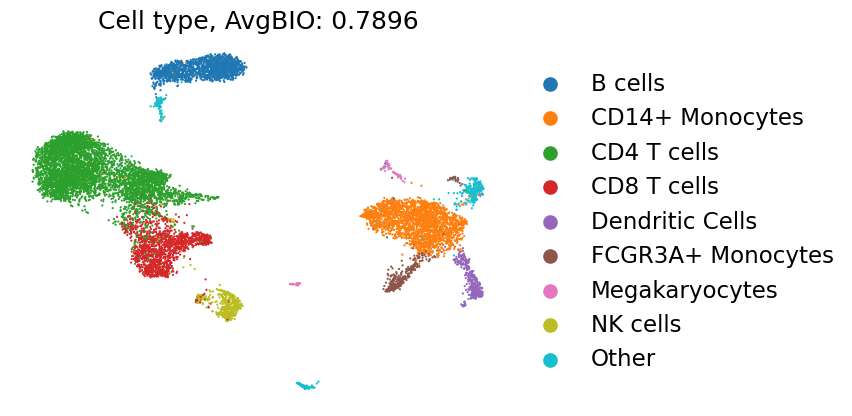

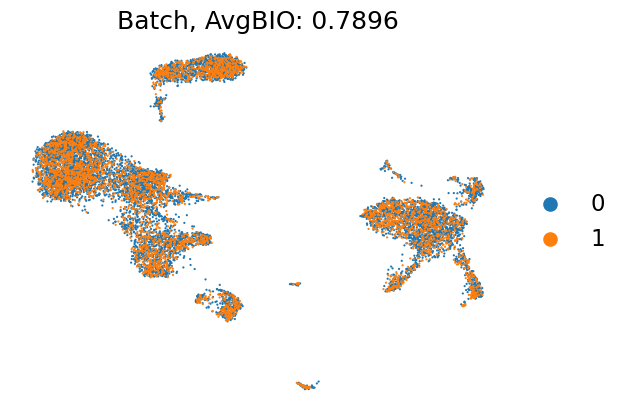

In [19]:
result_dict = evaluate(adata, data_path, save_result_dir, cfg, dataset.id2label)
print(result_dict)